In [1]:
import sys

In [2]:
sys.path.append('/home/p/reFUEL/syfop/')

In [3]:
import pathlib
import xarray as xr

In [4]:
import syfop

In [5]:
from syfop.util import *
from syfop.node import *
from syfop.network import *

In [6]:
%load_ext autoreload
%autoreload 2

## Parameters

In [7]:
location_id = 11

In [8]:
battery_cost = 33             # EUR/KWh/a
hydrogen_storage_cost = 74    # EUR/kg/a
co2_storage_cost = 0.049      # EUR/kg/a

electrolizer_cost = 30        # kW/a
pv_cost = 53                  # EUR/kW/a
wind_cost = 128               # EUR/kW/a

electrolizer_efficiency_multiplier = 1
# electrolizer_efficiency = 0.63 * electrolizer_efficiency_multiplier
# 0.63 is the value for energy -> energy, if h2 is measured in tons, we use 0.019 according to Jo:
#     der wert von 0.019 entspricht einer effizienz von 0.63
#     wenn wir 0.69 rechnen wollen, multiplizieren wir 0.019 mit 069/0.63
#     1 KWh electricty * 0.019 = 1 kg H2
electrolizer_convert_factor = 0.019 * 1e-3  # 1KWh --> 1 ton h2

# -- below here probably constant for all scenarios

methanol_synthesis_cost = 42.  # in EUR/KW/a - taken from result csv


balanceCO2H2 = 7.268519  # from gams file
# balanceCO2H2 * h2 = co2
# --> balanceCO2H2 * h2 + h2 = co2 + h2
# --> (balanceCO2H2 + 1) * h2 = co2 + h2
# --> h2 / (co2 + h2) = 1/(balanceCO2H2 + 1)
methanol_synthesis_input_proportions = {"co2": 1 - 1/(balanceCO2H2 + 1), "electrolizer": 1/(balanceCO2H2 + 1)}

methanolSysnthesisEff = 5.093 * 5.54 * 1e3
methanol_synthesis_convert_factor = 1/(balanceCO2H2 + 1) * methanolSysnthesisEff

storage_params = {
    'electricity':{
        'costs': battery_cost,
        'max_charging_speed': 0.4,   # taken from GAMS file (value from Jo)
        'storage_loss': 0,           # 
        'charging_loss': 0.1,        # 0.9 in gdx and result file
    },
    'co2': {
        'costs': 1e3 * co2_storage_cost,
        'max_charging_speed': 0.2,   # taken from GAMS file (value from Jo)
        'storage_loss': 0,
        'charging_loss': 0,
    },
    'hydrogen': {
        'costs': 1e3 * hydrogen_storage_cost,
        'max_charging_speed': 0.2,   # taken from GAMS file (value from Jo)
        'storage_loss': 0,
        'charging_loss': 0,
    },
}

## Read input data

In [9]:
DATA_DIR = pathlib.Path('..') / 'reproduce-brazil-paper' / 'land-neutral-renewable-fuels'

In [10]:
INPUT_DATA = DATA_DIR / 'input-data'

In [11]:
solar_pv_input_flow = d = xr.load_dataset(INPUT_DATA / 'pv-simulation' / 'pv_BRA_ERA5_land.nc')
solar_pv_input_flow = solar_pv_input_flow.pv.sel(epe_id=location_id,time=slice('2017-01-01', '2017-12-31'))

# PV time series are given in KW for a PV plant with 1MW capacity
# That means deviding by 1e3 gives us capacity factors:
solar_pv_input_flow = solar_pv_input_flow * 1e-3

In [12]:
assert (0 <= solar_pv_input_flow).all() and (solar_pv_input_flow <= 1).all()

In [13]:
wind_class2_input_flow = xr.load_dataset(INPUT_DATA / 'windpower-ethanol' / 'windpower_BRA_ERA5_GWA2_iecII.nc')
wind_class2_input_flow = wind_class2_input_flow.sel(epe_id=location_id,time=slice('2017-01-01', '2017-12-31')).wp

# for wind class 2 a 2000KW turbine has been used, so we devide by 2000 to get capacity factors
# see: land-neutral-renewable-fuels/input-data/techno-economic-parameters/windturbines.csv
wind_class2_input_flow = wind_class2_input_flow / 2000

In [14]:
wind_class3_input_flow = xr.load_dataset(INPUT_DATA / 'windpower-ethanol' / 'windpower_BRA_ERA5_GWA2_iecIII.nc')
wind_class3_input_flow = wind_class3_input_flow.sel(epe_id=location_id,time=slice('2017-01-01', '2017-12-31')).wp

# for wind class 3 a 3150KW turbine has been used, so we devide by 3150 to get capacity factors
# see: land-neutral-renewable-fuels/input-data/techno-economic-parameters/windturbines.csv
wind_class3_input_flow = wind_class3_input_flow / 3150

In [15]:
ethanol_plants = pd.read_csv(INPUT_DATA / 'ethanol-plants-brazil' / 'eth_consolidated_installations_and_statistics.csv')

In [16]:
# unit = tons
co2_input_flow = pd.read_csv(INPUT_DATA / 'ethanol-plants-brazil' / 'generated_e_demand_time_series' / str(ethanol_plants.original_index_epe[location_id]), parse_dates=['Unnamed: 0'])
co2_input_flow = xr.DataArray(co2_input_flow.CO2, coords={'time': co2_input_flow['Unnamed: 0']})
co2_input_flow = co2_input_flow.isel(time=slice(None, -1))  # exclude 1st January 2018

## Result file

In [17]:
# according to Johannes, this is the right file to look at (PV is enabled)
fname_result = DATA_DIR / 'results' / 'revisions2-runs-main-pv-manuscript.csv'
result = pd.read_csv(fname_result)

In [18]:
scenario_set = 'revisions2-runs-main-pv-manuscript'

In [19]:
scenario = f'bat_{battery_cost}-elyzerc_{electrolizer_cost}-h2storc_{hydrogen_storage_cost}-co2storc_{co2_storage_cost}-pvc{pv_cost}-windc{wind_cost}-eyzereffmult_{electrolizer_efficiency_multiplier}'

In [20]:
len(result[(result.scenario == scenario)])

339

In [21]:
len(result[(result['storageCost.co2'] == co2_storage_cost)
       & (result.electrolizerCost == electrolizer_cost)
       & (result['storageCost.electricity'] == battery_cost)
       & (result['storageCost.h2'] == hydrogen_storage_cost)
       & (result['cost.PV.tech1'] == pv_cost)
       & (result['increaseElectrolyzerEfficiency'] == electrolizer_efficiency_multiplier)
])

339

In [22]:
# alles was kapazität: GW (strom)
# alles was energie: GWh (strom, methanol)
# alles was co2 oder h2: kilotons (co2, h2)
# alles was total costs ist: million euro (costs)
# alles was unit costs ist: ansich eh input parameter, aber ist dann in mill euro pro unit wie oben

In [23]:
result[(result.scenario == scenario) & (result.epe_id == location_id)].T

,685
epe_id,11
x_electrolizerSize,0.027181
x_methanolSynthesisSize,0.012179
modelstatus,1.0
solvestatus,1.0
x_cost,6.1158
electrolizerCost,30.0
methanolSynthesisCost,42.0
co2UseProportion,1.0
increaseElectrolyzerEfficiency,1.0


## Why is wind attractive at all?

In [24]:
import matplotlib.pyplot as plt

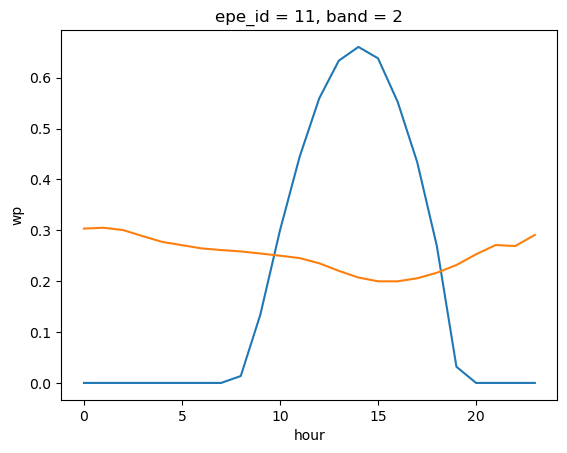

In [25]:
solar_pv_input_flow.groupby(solar_pv_input_flow.time.dt.hour).mean().plot()
wind_class2_input_flow.groupby(solar_pv_input_flow.time.dt.hour).mean().plot()

Text(0, 0.5, 'Generation per investment (KW/EUR/a)')

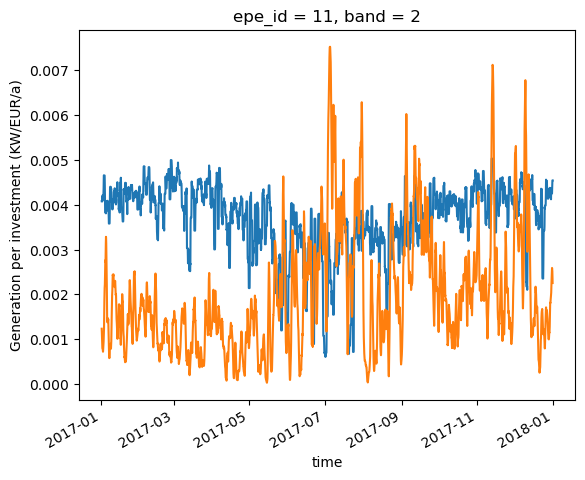

In [26]:
(solar_pv_input_flow / pv_cost).rolling(time=24).mean().plot()
(wind_class2_input_flow / wind_cost).rolling(time=24).mean().plot()
plt.ylabel('Generation per investment (KW/EUR/a)')

## Model

In [27]:
# note: for now we don't distinguish between KW and KWh (per time stamp), this is okayish since we have hourly time stamps

solar_pv = NodeScalableInputProfile(
    name="solar_pv",
    input_flow=solar_pv_input_flow,
    costs=pv_cost,
    output_unit="KW",
)
wind_class2 = NodeScalableInputProfile(
    name="wind_class2",
    input_flow=wind_class2_input_flow,
    costs=wind_cost,
    output_unit="KW",
)
wind_class3 = NodeScalableInputProfile(
    name="wind_class3",
    input_flow=wind_class3_input_flow,
    costs=wind_cost,
    output_unit="KW",
)
co2 = NodeFixInputProfile(
    name="co2",
    costs=0,
    input_flow=co2_input_flow,
    output_unit="t",
    storage=Storage(**storage_params['co2']),
)
electricity = Node(
    name="electricity",
    inputs=[solar_pv, wind_class2, wind_class3],
    input_commodities="electricity",
    costs=0,
    storage=Storage(**storage_params['electricity']),
    output_unit="KW",
)
curtail_electricity = Node(
    name="curtail_electricity",
    inputs=[electricity],
    input_commodities="electricity",
    costs=0,
    output_unit="KW",
)
electrolizer = Node(
    name="electrolizer",
    inputs=[electricity],
    input_commodities="electricity",
    costs=electrolizer_cost,
    convert_factor=electrolizer_convert_factor,
    output_unit="t",
    storage=Storage(**storage_params['hydrogen']),
)
curtail_hydrogen = Node(
    name="curtail_hydrogen",
    inputs=[electrolizer],
    input_commodities="hydrogen",
    costs=0,
    output_unit="t",
)

methanol_synthesis = Node(
    name="methanol_synthesis",
    inputs=[co2, electrolizer],
    input_commodities=["co2", "hydrogen"],
    costs=methanol_synthesis_cost,
    convert_factor=methanol_synthesis_convert_factor,
    output_unit="KW",
    input_proportions=methanol_synthesis_input_proportions,
)

network = Network(
    [
        solar_pv,
        wind_class2,
        wind_class3,
        electricity,
        curtail_electricity,
        electrolizer,
        curtail_hydrogen,
        co2,
        methanol_synthesis,
    ],
    time_coords=solar_pv_input_flow.time,
)

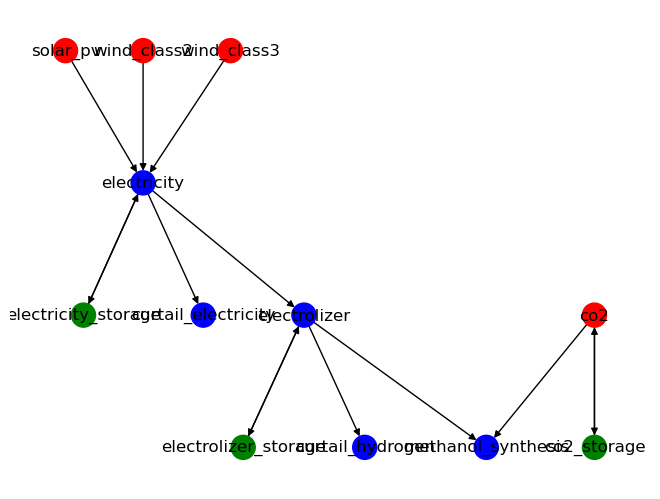

In [28]:
network.draw()

In [29]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/home/p/HiGHS/build/bin"
os.environ['GRB_LICENSE_FILE'] = '/opt/gurobi810/gurobi.lic'

In [30]:
network.optimize('gurobi')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-01
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 236520 rows, 175208 columns and 590800 nonzeros
Model fingerprint: 0x189b57a1
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [3e+01, 7e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 4e+00]
Presolve removed 104142 rows and 95382 columns
Presolve time: 2.65s
Presolved: 42981 rows, 137636 columns, 682449 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Free vars  : 4809
 AA' NZ     : 5.356e+05
 Factor NZ  : 1.043e+06 (roughly 80 MB of memory)
 Factor Ops : 2.667e+07 (less than 1 second per iteration)
 Threads    : 3

             

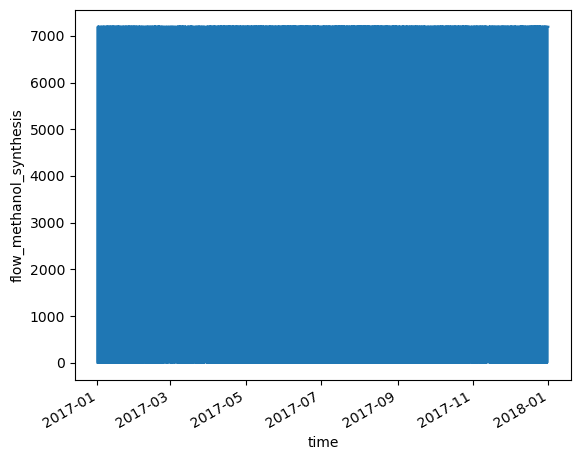

In [31]:
network.model.solution.flow_methanol_synthesis.plot()

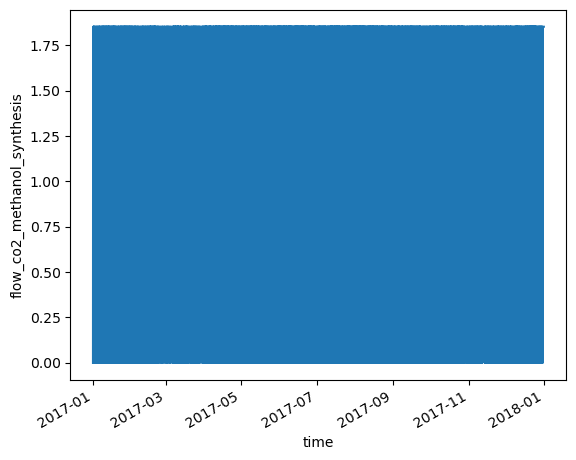

In [32]:
network.model.solution.flow_co2_methanol_synthesis.plot()

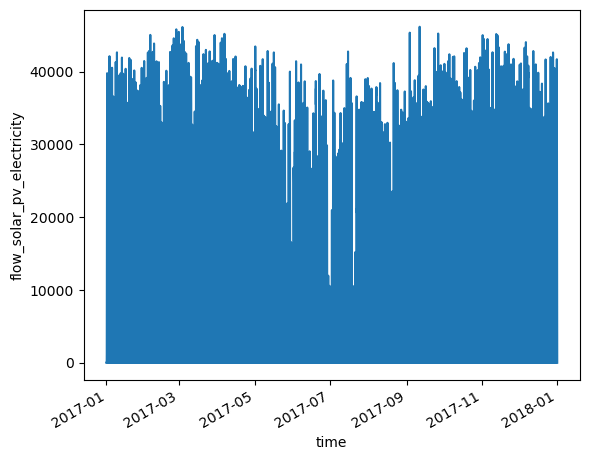

In [33]:
network.model.solution.flow_solar_pv_electricity.plot()

In [34]:
network.model.solution

<xarray.Dataset>
Dimensions:                               (time: 8760)
Coordinates:
  * time                                  (time) datetime64[ns] 2017-01-01 .....
Data variables: (12/28)
    size_solar_pv                         float64 5.19e+04
    size_wind_class2                      float64 0.0
    size_wind_class3                      float64 0.0
    flow_solar_pv_electricity             (time) float64 0.0 0.0 0.0 ... 0.0 0.0
    flow_wind_class2_electricity          (time) float64 0.0 0.0 0.0 ... 0.0 0.0
    flow_wind_class3_electricity          (time) float64 0.0 0.0 0.0 ... 0.0 0.0
    ...                                    ...
    flow_co2_methanol_synthesis           (time) float64 0.0 1.853 ... 1.853
    flow_electrolizer_methanol_synthesis  (time) float64 0.0 0.255 ... 0.255
    size_methanol_synthesis               float64 7.195e+03
    flow_curtail_electricity              (time) float64 0.0 0.0 0.0 ... 0.0 0.0
    flow_curtail_hydrogen                 (time) float64 0.0 0.0 0.0 ... 0.0 0.0
    flow_methanol_synthesis               (time) float64 0.0 ... 7.195e+03

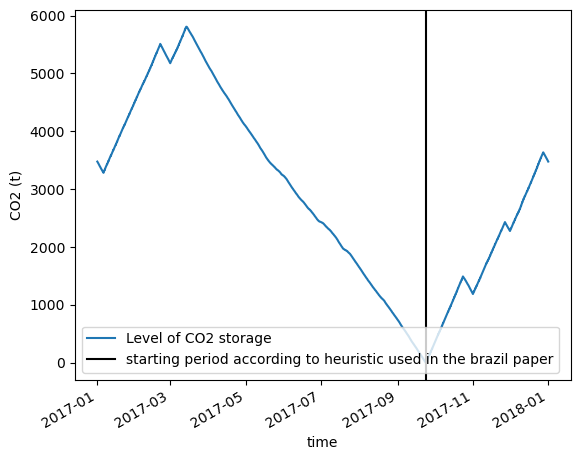

In [35]:
network.model.solution.storage_level_co2.plot(label='Level of CO2 storage')
start_brazil_paper = co2_input_flow.time.isel(time=(co2_input_flow - co2_input_flow.mean()).cumsum().argmin() + 1).values
plt.axvline(
    start_brazil_paper, color='k',
    label='starting period according to heuristic used in the brazil paper'
)
plt.ylabel('CO2 (t)')
plt.legend();

## Compare results

In [36]:
mapping = {
    'size_solar_pv': ('x_resBuild.PV.tech1', 'KW', 1e6),                    # KW / GW
    'size_wind_class2': ('x_resBuild.Wind.tech1', 'KW', 1e6),               # KW / GW
    'size_wind_class3': ('x_resBuild.Wind.tech2', 'KW', 1e6),               # KW / GW
    'size_storage_electricity': ('x_storageSize.electricity', 'KWh', 1e6),  # KWh / GWh
    'size_storage_electrolizer': ('x_electrolizerSize', 'KWh', 1e3),        # t / kt
    'size_electrolizer': ('x_electrolizerSize', 't', 1e3),                  # t / kt
    'size_storage_co2': ('x_storageSize.co2', 't', 1e3),                    # t / kt
    'size_methanol_synthesis': ('x_methanolSynthesisSize', 'KW', 1e6),      # KW / GW
}

In [37]:
result_paper_scenario = result[(result.scenario == scenario) & (result.epe_id == location_id)]

In [38]:
result_comparison = pd.DataFrame({f"{key_new} ({unit})":
    [
        network.model.solution[key_new].values,
        factor * result_paper_scenario[key_paper].iloc[0]
    ]
    for key_new, (key_paper, unit, factor) in mapping.items()}, index=('Syfop', 'Paper')).T

In [39]:
result_comparison.loc['total_costs (EUR)'] = [
    network.model.objective_value,
    result_paper_scenario.x_cost.iloc[0] * 1e6
]

In [40]:
result_comparison['rel_error'] = result_comparison['Syfop'] / result_comparison['Paper'] - 1

In [41]:
result_comparison

,Syfop,Paper,rel_error
size_solar_pv (KW),51897.95434904421,29637.342548,0.7511
size_wind_class2 (KW),0.0,0.0,NaN
size_wind_class3 (KW),0.0,21631.764718,-1.0
size_storage_electricity (KWh),0.0,0.0,NaN
size_storage_electrolizer (KWh),3.6787580847880745,27.181492,-0.864659
size_electrolizer (t),0.25498799507415926,27.181492,-0.990619
size_storage_co2 (t),5807.5241615897785,8207.683884,-0.292428
size_methanol_synthesis (KW),7194.542378376319,12179.047149,-0.409269
total_costs (EUR),3609566.792223,6115800.254851,-0.409796


In [50]:
network.model.constraints

linopy.model.Constraints
------------------------

Dimensions:                                     (time: 8760)
Coordinates:
    epe_id                                      int64 11
  * time                                        (time) datetime64[ns] 2017-01...
    band                                        int64 2

Labels:
    inout_flow_balance_solar_pv                 (time) int64 0 1 2 ... 8758 8759
    inout_flow_balance_wind_class2              (time) int64 8760 8761 ... 17519
    limit_outflow_by_size_wind_class2           (time) int64 17520 ... 26279
    inout_flow_balance_wind_class3              (time) int64 26280 ... 35039
    limit_outflow_by_size_wind_class3           (time) int64 35040 ... 43799
    inout_flow_balance_electricity              (time) int64 43800 ... 52559
    ...                                          ...
    storage_max_level_co2                       (time) int64 183960 ... 192719
    storage_level_balance_co2                   (time) int64 192720 ..

In [49]:
network.model.solution.size_solar_pv.max()

<xarray.DataArray 'size_solar_pv' ()>
array(51897.95434904)

In [42]:
# why is the electrolizer that small??
#  - do we have a reasonable amount of H2?
#  - is the electroizer capacity really in kt in the paper?

## Debug the model

In [43]:
# constraints_as_str = constraints_to_str(network.model)

In [44]:
# with open('/tmp/model', 'w+') as f:
#    f.write(constraints_as_str)